# Overview
1. Define the MobileNet V2 model architecture in pure PyTorch.
2. Visualize the .pt model architecture using GraphViz
3. Init and profile model using raw PyTorch format
4. Use torch.compile() to speed-up raw PyTorch format
4. Export the model to .onnx format and profile in ONNXRuntime
5. Convert the .onnx model to TensorRT .engine and profile using TensorRT Runtime


The setup used for this test is:
|CPU | RAM | GPU |
|----|-----|-----|
| i9-13900k | 64 GB | RTX4080 16GB |

## 1. Model Definition
We will use the MobileNet V2 architecture, using the following parameters:
|Number of Classes|Input Size|Width Multiplier|
|-----------------|----------|----------------|
| 2 | 224x224 | 1.0|
|the output of the model will have len() = 2 instead of 1000 which is the pre-trained value on ImageNet.| the size of the images we'll pass through the network| Number of channels in the layers are scaled according to this factor. (e.g 0.5 will half the network width, 1.0 keeps it's default etc)|

References:
- [Detailed explanation on PapersWithCode](https://paperswithcode.com/method/mobilenetv2)

In [2]:
import math
import numpy as np
from torch import nn

# A convolution + batch norm block
# Takes input channels and 
def conv_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


def make_divisible(x, divisible_by=8):
    import numpy as np
    return int(np.ceil(x * 1. / divisible_by) * divisible_by)


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(inp * expand_ratio)
        self.use_res_connect = self.stride == 1 and inp == oup

        if expand_ratio == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(self, n_class=1000, input_size=224, width_mult=1.):
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32
        last_channel = 1280
        interverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        assert input_size % 32 == 0
        
        self.last_channel = make_divisible(last_channel * width_mult) if width_mult > 1.0 else last_channel
        self.features = [conv_bn(3, input_channel, 2)]
        
        # Building the IRB blocks (Inverted Residual Blocks)
        for t, c, n, s in interverted_residual_setting:
            output_channel = make_divisible(c * width_mult) if t > 1 else c
            for i in range(n):
                if i == 0:
                    self.features.append(block(input_channel, output_channel, s, expand_ratio=t))
                else:
                    self.features.append(block(input_channel, output_channel, 1, expand_ratio=t))
                input_channel = output_channel
        
        self.features.append(conv_1x1_bn(input_channel, self.last_channel))
        self.features = nn.Sequential(*self.features)

        # Building last layer classifier
        self.classifier = nn.Linear(self.last_channel, n_class)
        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.mean(3).mean(2)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()


# 2. Visualizing the model architecture with GraphViz

It will save the model architecture as mobilenetv2.png.

#### Notes:
When running torchviz, we have different colors for each layer block, here's what they mean:
- BLUE = Tensors that require .grad (weights & bias will be updated during backpropagation)
- ORANGE = Saved tensors of custom Torch Autograd functions
- GREEN = Tensor passed as outputs, for exchange.

In [3]:
import torch
from torchviz import make_dot
from torch.autograd import Variable

model = MobileNetV2(n_class=2, input_size=224, width_mult=1.)
dummy_input = Variable(torch.randn(1, 3, 224, 224))

# Records the graph of operations
y = model(dummy_input)

# Renders recorded graph
model_graph = make_dot(y, params=dict(model.named_parameters()))

# Visualisation stuff only, we're rescaling the size of the nodes in the graph
# to be able to visualize here inside the notebook
model_graph.format = 'png'
model_graph.render('mobilenetv2')
model_graph.attr(size='8,6')

from IPython.display import Image
display(Image('mobilenetv2.png'))

# 3. Profilling model in raw PyTorch

- We will use dummy input tensors, since our goal is to track performance only
- Stats of profilling will be kept in a `timings` dict

In [13]:
import torch
import time

num_runs = 100
timings = {
    "pytorch": [],
}

model = MobileNetV2(n_class=2, input_size=224, width_mult=1.0)
model = model.eval()

inp_tensor_shape = (1, 3, 224, 224)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# Raw Pytorch Inference Time
with torch.no_grad():
    for _ in range(num_runs):
        inp = torch.randn(*inp_tensor_shape).to(device)
        st = time.time_ns()
        model(inp)
        en = time.time_ns()
        timings["pytorch"].append(en - st)

# 4. Profilling PyTorch compiled model
- We will first define the model, then compile it using `torch.compile()` and then run profilling.

In [14]:
import torch
import time

num_runs = 100
timings.update({"pytorch_compiled": []})

model = MobileNetV2(n_class=2, input_size=224, width_mult=1.0)
model = model.eval()

# Compile the model using TorchInductor primitives
torch.compile(model=model, backend="inductor")

inp_tensor_shape = (1, 3, 224, 224)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# Raw Pytorch Inference Time
with torch.no_grad():
    for _ in range(num_runs):
        inp = torch.randn(*inp_tensor_shape).to(device)
        st = time.time_ns()
        model(inp)
        en = time.time_ns()
        timings["pytorch_compiled"].append(en - st)

# 5. Exporting PyTorch to ONNX and profilling ONNXRuntime
We're going to use the same MobileNetv2 model as above, but will provide specific ONNX parameters.
We're setting the model to `.eval()` to freeze batch_normalisation and dropout layers. This key when working with models in inference/export scenarions.

When converting to ONNX, here are the key parameters to keep in mind:
- `model` : Represents our nn.Module (actual model implementation)
- `f` : Represents the file .onnx where we're going to serialize the model
- `input_names` : Here we specify the name (names if multiple) of the input layers
- `output_names`: Here we specify the name (names if multiple) of the output layers
- `opset_version`: Since ONNX is a standardized format to represent models, the opset_version represents the version of operators used in the ONNX graph, such that they can be interpreted by other frameworks.
- `do_constant_folding`: Is a flag that tells the export process to pre-compute values at compile time. This is an ONNX optimization technique, because constants doesn't change, we don't need to define them each time we run the model.

#### Extra:
- We can visualize the ONNX model using Netron

In [20]:
import onnx
import torch
import numpy as np
import time
import onnxruntime as ort

timings.update({"onnxruntime": []})

model = MobileNetV2(n_class=2, input_size=224, width_mult=1.0)
model.eval()

torch.onnx.export(
    model=model,
    args=torch.randn(1, 3, 224, 224),
    f="./core/mobilenetv2.onnx",
    verbose=False,
    input_names=["input"],
    output_names=["output"],
    opset_version=17,
    do_constant_folding=True,
)

# Checking the ONNX model

onnx_model = onnx.load("./core/mobilenetv2.onnx")
onnx.checker.check_model(onnx_model)

# Profilling the onnx model
provider = "CUDAExecutionProvider" if torch.cuda.is_available() else "CPUExecutionProvider"
ort_session = ort.InferenceSession("./core/mobilenetv2.onnx", providers=[provider])
input_name = ort_session.get_inputs()[0].name
inp_tensor_shape = (1, 3, 224, 224)

for _ in range(num_runs):
    inp = np.random.rand(*inp_tensor_shape).astype(np.float32)
    st = time.time_ns()
    ort_session.run(None, {input_name: inp})
    en = time.time_ns()
    timings["onnxruntime"].append(en - st)



/home/razvantalexandru/.cache/pypoetry/virtualenvs/001-inference-engines-RG1v7pFq-py3.11/lib/python3.11/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


# Visualizing PyTorch vs PyTorch Compiled vs ONNXRuntime

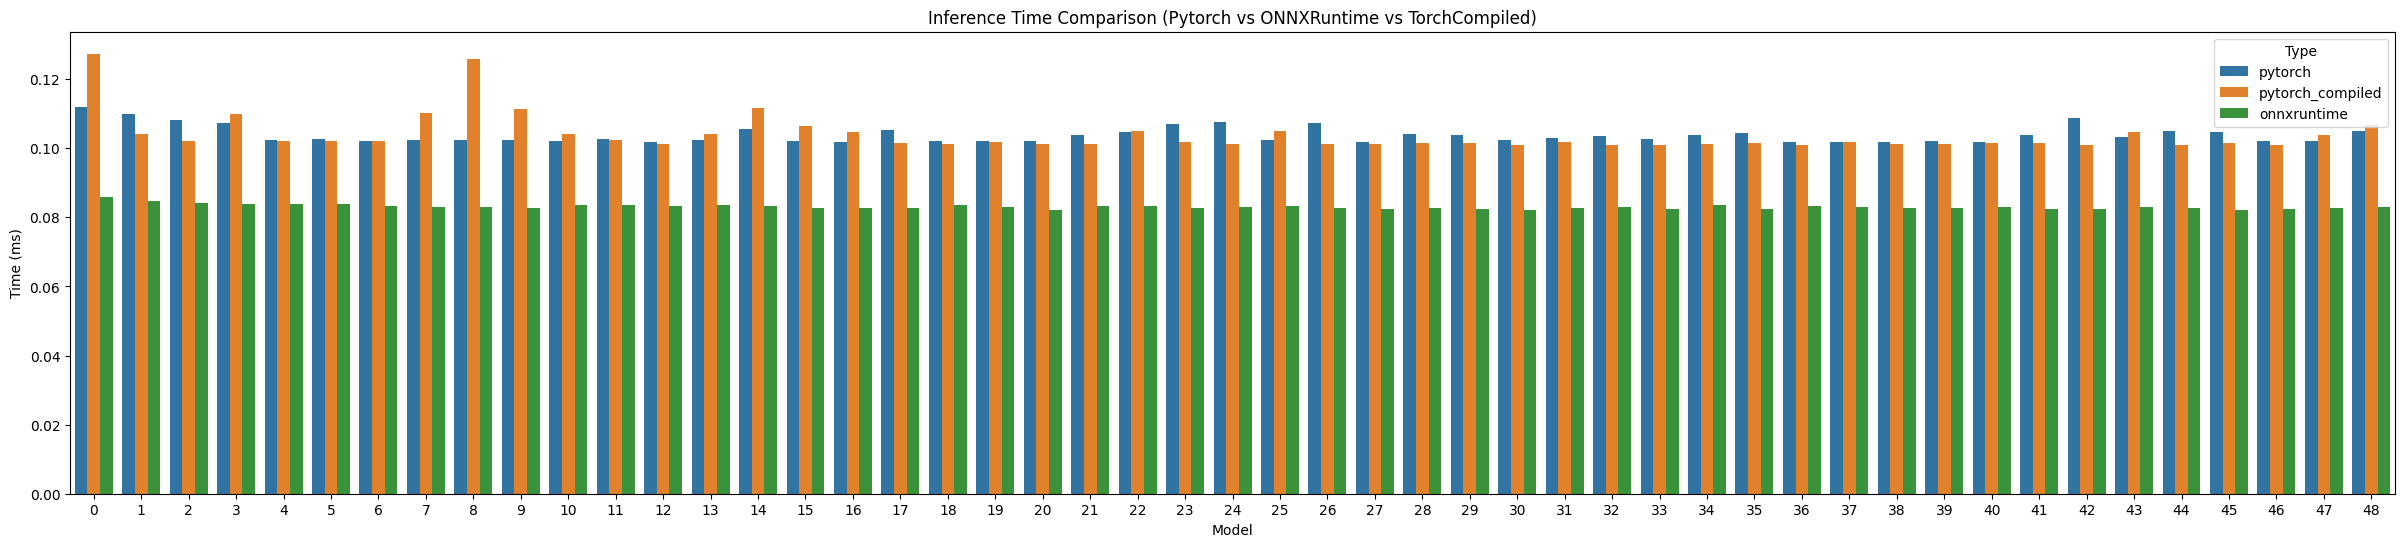

In [16]:
# Plot timings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

# We'll skip the first, because or models are not warmed up, and stop at 50/100 for a better plot

slicing_window = (1, 50)


torch_timings = timings["pytorch"][slicing_window[0]:slicing_window[1]]
onnxruntime_timings = timings["onnxruntime"][slicing_window[0]:slicing_window[1]]
torch_compiled_timings = timings["pytorch_compiled"][slicing_window[0]:slicing_window[1]]
timings = {
    "pytorch": torch_timings,
    "pytorch_compiled": torch_compiled_timings,
    "onnxruntime": onnxruntime_timings,
}
timings_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in timings.items()]))
timings_df["Model"] = timings_df.index
timings_df = timings_df.apply(lambda x: x / 10e6 if x.name != "Model" else x)

timings_df = timings_df.melt(id_vars="Model", var_name="Type", value_name="Time (ms)")

plt.figure(figsize=(30, 6))
sns.barplot(x="Iteration Time", y="Time (ms)", hue="Type", data=timings_df)
plt.title("Inference Time Comparison (Pytorch vs ONNXRuntime vs TorchCompiled)")
plt.show()

# 7. Profilling TensorRT
In order to profile the TensorRT engine, we need to convert the ONNX model format to an TensorRT engine format.
The recommended way to work with the TensorRT Compiler is from within it's version bundle specific container from NVIDIA.

- To make sure we're using the same features across, and the comparison is fair we must check the Container Version which includes the PyTorch version we've used across the experiments above.
    - Let's head over to [NVIDIA's Compatibility Matrix](https://docs.nvidia.com/deeplearning/frameworks/support-matrix/index.html)
    - We see that under Container Version 23.X we have Torch 2.0+ version supported
    - We'll use TensorRT Container 23.03 which is compatible with Torch 2.0.0a0
- For the entire workflow, we could run commands sequentially using the Terminal or from Python using the `docker` package.

In [37]:
import os
import docker

# Pull TensorRT-24.05 Container
client = docker.from_env()
container_image = "nvcr.io/nvidia/tensorrt:23.03-py3"
client.images.pull(container_image)

# Starting the container, referencing the `core` directory
container = client.containers.run(
    container_image,
    detach=True,
    volumes={
        f"{os.getcwd()}/core": {
            "bind": "/workspace",
            "mode": "rw",
        }
    },
    tty=True,
    device_requests=[docker.types.DeviceRequest(count=-1, capabilities=[['gpu']])]
)

try:
    # Running the TensorRT conversion script
    code, output = container.exec_run(
        cmd="trtexec --onnx=/workspace/mobilenetv2.onnx --saveEngine=/workspace/mobilenetv2.engine",
        tty=True,
    )
    
    print(f"[ExportingModel] [ExitCode]:{code} - [Output] : {output.decode()}")
    
    # Running the tensorr profilling script and recording metrics in a file
    code, output = container.exec_run(
        cmd="python tensorrt_benchmark.py --engine_path /workspace/mobilenetv2.engine --num_runs 100",
        tty=True,
    )
    print(f"[Profilling Model] [ExitCode]:{code} - [Output] : {output.decode()}")
    
finally:
    container.stop()
    container.remove()

[Profilling Model] [ExitCode]:0 - [Output] : tensorrt_benchmark.py:52: DeprecationWarning: Use get_tensor_shape instead.
  trt.volume(self.engine.get_binding_shape(binding)) * self.max_batch_size
tensorrt_benchmark.py:59: DeprecationWarning: Use get_tensor_mode instead.
  if self.engine.binding_is_input(binding):
tensorrt_benchmark.py:75: DeprecationWarning: Use execute_async_v2 instead.
  self.context.execute_async(
[08/05/2024-18:14:42] [TRT] [W] The enqueue() method has been deprecated when used with engines built from a network created with NetworkDefinitionCreationFlag::kEXPLICIT_BATCH flag. Please use enqueueV2() instead.
[08/05/2024-18:14:42] [TRT] [W] Also, the batchSize argument passed into this function has no effect on changing the input shapes. Please use setBindingDimensions() function to change input shapes instead.
[08/05/2024-18:14:42] [TRT] [W] The enqueue() method has been deprecated when used with engines built from a network created with NetworkDefinitionCreationFla

In [38]:
# Plot timings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

# We select number of samples to plot
# We'll skip the first, because or models are not warmed up, and stop at 50/100 for a better plot

slicing_window = (1, 50)

# Loading TensorRT Timings
trt_timings = open("./core/trt_benchmark.txt", "r").readlines()
trt_timings = [int(x.strip()) for x in trt_timings[slicing_window[0]:slicing_window[1]]]

torch_timings = timings["pytorch"][slicing_window[0]:slicing_window[1]]
onnxruntime_timings = timings["onnxruntime"][slicing_window[0]:slicing_window[1]]
torch_compiled_timings = timings["pytorch_compiled"][slicing_window[0]:slicing_window[1]]
timings = {
    "pytorch": torch_timings,
    "pytorch_compiled": torch_compiled_timings,
    "onnxruntime": onnxruntime_timings,
    "tensorrt": trt_timings
}
timings_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in timings.items()]))
timings_df["Model"] = timings_df.index
timings_df = timings_df.apply(lambda x: x / 10e6 if x.name != "Model" else x)

timings_df = timings_df.melt(id_vars="Model", var_name="Type", value_name="Time (ms)")

plt.figure(figsize=(30, 6))
sns.barplot(x="Model", y="Time (ms)", hue="Type", data=timings_df)
plt.title("Inference Time Comparison (Pytorch vs ONNXRuntime vs TensorRT vs TorchCompiled)")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'trt_benchmark.txt'